# Library import

In [1]:
import cv2
print(cv2.__version__)
print(hasattr(cv2, 'ximgproc'))


4.10.0
True


In [2]:
# 필요 library들을 import합니다.
import os
from typing import Tuple, Any, Callable, List, Optional, Union

import cv2
import timm
import torch
import random
import numpy as np
import pandas as pd
import albumentations as A
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt

# from torchcam.methods import GradCAM
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import StratifiedKFold

/opt/conda/envs/blueberry/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print(torch.cuda.is_available())

True


In [4]:
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Dataset Class

## BPD & MSR

In [5]:
import cv2
import numpy as np

def bezier_pivot_deformation(image, num_deformations=6, deformation_degree=10): # 원본 이미지로부터 6개의 변형된 이미지를 생성
    """
    Applies Bezier pivot based deformation (BPD) on a sketch image.

    Args:
    - image (numpy.ndarray): The input sketch image.
    - num_deformations (int): Number of deformations to generate.
    - deformation_degree (int): The degree of random shift for control pivots.
    
    Returns:
    - List of deformed images.
    """
    def fit_bezier_curve(points):
        # Fit a cubic Bezier curve to the points using least squares method
        n = len(points)
        t = np.linspace(0, 1, n)
        phi = 1 - t
        A = np.vstack([phi**3, 3*t*phi**2, 3*t**2*phi, t**3]).T
        B = np.linalg.lstsq(A, points, rcond=None)[0]
        return B

    def deform_curve(p0, p1, p2, p3, alpha=deformation_degree):
        # Randomly deform the control pivots
        delta = np.random.uniform(-alpha, alpha, size=(2,))
        return p0, p1 + delta, p2 + delta, p3

    # Step 1: Convert image to binary and skeletonize
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
    skeleton = cv2.ximgproc.thinning(binary)

    # Step 2: Segment into patches and deform curves
    patches = []
    patch_size = 32
    h, w = skeleton.shape
    for y in range(0, h, patch_size):
        for x in range(0, w, patch_size):
            patch = skeleton[y:y + patch_size, x:x + patch_size]
            patches.append(patch)

    deformed_images = []
    for _ in range(num_deformations):
        new_image = np.zeros_like(skeleton)
        for patch in patches:
            # Fit Bezier curve to patch
            y, x = np.where(patch > 0)
            if len(x) > 3:
                points = np.column_stack((x, y))
                p0, p1, p2, p3 = fit_bezier_curve(points)

                # Deform curve using random shifts
                p0, p1, p2, p3 = deform_curve(p0, p1, p2, p3)

                # Reconstruct the patch with deformed curve
                new_image[y, x] = 255
        deformed_images.append(new_image)

    return deformed_images


HOG feature min: 0.0
HOG feature max: 0.9999999987499999
HOG feature shape: (350, 81)
Cluster centers shape: (150, 81)
Labels shape: (350,)
Mean stroke before scaling: [0.23066286 0.         0.06715685 0.         0.66902609 0.
 0.62088204 0.         0.         0.16018966 0.         0.0378671
 0.         0.69166531 0.         0.64677111 0.         0.
 0.12219927 0.         0.03092436 0.         0.7848782  0.
 0.4368134  0.         0.         0.09018331 0.         0.0086775
 0.         0.32117308 0.         0.84727518 0.         0.
 0.00942983 0.         0.00230892 0.         0.01405428 0.
 0.99150615 0.         0.         0.0160721  0.         0.00405023
 0.         0.02558199 0.         0.97984564 0.         0.
 0.09408861 0.         0.00634634 0.         0.23117507 0.
 0.63597037 0.         0.         0.01841892 0.         0.00408666
 0.         0.0109172  0.         0.98915792 0.         0.
 0.03540087 0.         0.0120878  0.         0.03227536 0.
 0.97286116 0.         0.        ]


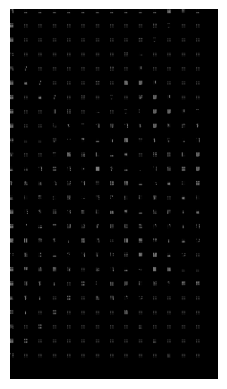

In [31]:
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.cluster import KMeans

# 패치 추출 및 HOG 특징 계산 함수
def extract_patches_and_hog_features(image, patch_size=31):
    """
    주어진 이미지에서 패치를 추출하고, 각 패치의 HOG 특징을 계산하는 함수.
    
    Args:
    - image (numpy.ndarray): 입력 이미지.
    - patch_size (int): 패치의 크기.
    
    Returns:
    - patches (List): 패치의 리스트.
    - hog_features (List): HOG 특징의 리스트.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
    skeleton = cv2.ximgproc.thinning(binary)

    h, w = skeleton.shape
    patches = []
    hog_features = []
    
    for y in range(0, h, patch_size):
        for x in range(0, w, patch_size):
            patch = skeleton[y:y + patch_size, x:x + patch_size]
            if patch.shape[0] == patch_size and patch.shape[1] == patch_size:  # 패치 크기 확인
                patches.append((patch, (x, y)))
                hog_feature = hog(patch, pixels_per_cell=(8, 8), cells_per_block=(1, 1), feature_vector=True)
                hog_features.append(hog_feature)
    
    return patches, np.array(hog_features)  # 리스트를 NumPy 배열로 변환

# 클러스터 중심 계산 함수
def compute_cluster_centers(images, n_clusters=150, patch_size=31):
    """
    여러 이미지에서 HOG 특징을 추출하고, 이를 KMeans로 클러스터링하여 클러스터 중심을 계산.
    
    Args:
    - images (List of np.ndarray): 학습 이미지들의 리스트.
    - n_clusters (int): 클러스터 개수.
    - patch_size (int): 각 패치의 크기.
    
    Returns:
    - cluster_centers (np.ndarray): 계산된 클러스터 중심.
    """
    all_hog_features = []
    
    # 모든 이미지에서 패치와 HOG 특징 추출
    for image in images:
        _, hog_features = extract_patches_and_hog_features(image, patch_size)
        all_hog_features.extend(hog_features)
    
    # KMeans로 클러스터링
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(all_hog_features)
    
    return kmeans.cluster_centers_


def mean_stroke_reconstruction(image, cluster_centers, patch_size=31):
    patches, hog_features = extract_patches_and_hog_features(image, patch_size)

    print("HOG feature min:", np.min(hog_features))
    print("HOG feature max:", np.max(hog_features))
    print("HOG feature shape:", hog_features.shape)

    unique_hog_features = np.unique(hog_features, axis=0)
    num_clusters = min(150, len(unique_hog_features))

    kmeans = KMeans(n_clusters=num_clusters).fit(unique_hog_features)
    labels = kmeans.predict(hog_features)

    print("Cluster centers shape:", cluster_centers.shape)
    print("Labels shape:", labels.shape)

    new_image = np.zeros_like(image)

    for i, (patch, (x, y)) in enumerate(patches):
        mean_stroke = cluster_centers[labels[i]]

        print("Mean stroke before scaling:", mean_stroke)

        # mean_stroke를 0~255 범위로 스케일링
        mean_stroke = (mean_stroke - np.min(mean_stroke)) / (np.max(mean_stroke) - np.min(mean_stroke)) * 255
        mean_stroke = mean_stroke.astype(np.uint8)

        hog_length = len(mean_stroke)
        side_length = int(np.sqrt(hog_length))

        reshaped_patch = np.reshape(mean_stroke, (side_length, side_length))

        if len(new_image.shape) == 3 and new_image.shape[2] == 3:
            reshaped_patch = cv2.cvtColor(reshaped_patch, cv2.COLOR_GRAY2RGB)

        new_image[y:y + side_length, x:x + side_length] = reshaped_patch

        # 각 파치가 이미지에 제대로 적용되었는지 확인
        print(f"Applied patch at position ({x}, {y})")

    return new_image

# 예시 사용법
image = cv2.imread('./data/train/n01443537/sketch_3.JPEG', cv2.IMREAD_COLOR)
result_image = mean_stroke_reconstruction(image, cluster_centers)
plt.imshow(result_image)
plt.axis('off')
plt.show()



# def mean_stroke_reconstruction(image, cluster_centers, patch_size=31):
#     patches, hog_features = extract_patches_and_hog_features(image, patch_size)

#     # 중복 제거
#     unique_hog_features = np.unique(hog_features, axis=0)
#     num_clusters = min(150, len(np.unique(hog_features, axis=0)))  # 고유한 포인트 수에 맞춰 클러스터 수 조정
    
#     kmeans = KMeans(n_clusters=num_clusters).fit(unique_hog_features)
#     labels = kmeans.predict(hog_features)

#     new_image = np.zeros_like(image)

#     for i, (patch, (x, y)) in enumerate(patches):
#         mean_stroke = cluster_centers[labels[i]]

#         # mean_stroke 값을 0~255 범위로 스케일링
#         mean_stroke = (mean_stroke - np.min(mean_stroke)) / (np.max(mean_stroke) - np.min(mean_stroke)) * 255
#         mean_stroke = mean_stroke.astype(np.uint8)

#         hog_length = len(mean_stroke)
#         side_length = int(np.sqrt(hog_length))

#         reshaped_patch = np.reshape(mean_stroke, (side_length, side_length))

#         if len(new_image.shape) == 3 and new_image.shape[2] == 3:
#             reshaped_patch = cv2.cvtColor(reshaped_patch, cv2.COLOR_GRAY2RGB)

#         new_image[y:y + side_length, x:x + side_length] = reshaped_patch

#     return new_image


# def mean_stroke_reconstruction(image, cluster_centers, patch_size=31):
#     patches, hog_features = extract_patches_and_hog_features(image, patch_size)

#     # 중복 제거
#     unique_hog_features = np.unique(hog_features, axis=0)
#     num_clusters = min(150, len(np.unique(hog_features, axis=0)))  # 고유한 포인트 수에 맞춰 클러스터 수 조정
    
#     kmeans = KMeans(n_clusters=num_clusters).fit(unique_hog_features)
#     labels = kmeans.predict(hog_features)

#     new_image = np.zeros_like(image)

#     for i, (patch, (x, y)) in enumerate(patches):
#         mean_stroke = cluster_centers[labels[i]]
        
#         hog_length = len(mean_stroke)
#         side_length = int(np.sqrt(hog_length))

#         reshaped_patch = np.reshape(mean_stroke, (side_length, side_length))

#         if len(new_image.shape) == 3 and new_image.shape[2] == 3:
#             reshaped_patch = cv2.cvtColor(reshaped_patch.astype(np.uint8), cv2.COLOR_GRAY2RGB)

#         new_image[y:y + side_length, x:x + side_length] = reshaped_patch

#     return new_image



# def mean_stroke_reconstruction(image, cluster_centers, patch_size=31):
#     """
#     계산된 클러스터 중심을 사용하여 입력 이미지에 Mean Stroke Reconstruction을 적용하는 함수.
    
#     Args:
#     - image (numpy.ndarray): 입력 스케치 이미지.
#     - cluster_centers (List): 미리 계산된 클러스터 중심 리스트.
#     - patch_size (int): 패치 크기.
    
#     Returns:
#     - Reconstructed image (numpy.ndarray): 재구성된 이미지.
#     """
#     patches, hog_features = extract_patches_and_hog_features(image, patch_size)
    
#     # 각 패치를 클러스터 중심으로 대체
#     kmeans = KMeans(n_clusters=len(cluster_centers)).fit(hog_features)
#     labels = kmeans.predict(hog_features)

#     new_image = np.zeros_like(image)

#     # 패치의 크기 및 HOG 벡터 크기를 고려한 수정
#     for i, (patch, (x, y)) in enumerate(patches):
#         mean_stroke = cluster_centers[labels[i]]
        
#         # HOG 벡터의 길이를 기반으로 패치 크기 맞추기 (변환에 맞게 조정)
#         hog_length = len(mean_stroke)
#         side_length = int(np.sqrt(hog_length))  # HOG 벡터 크기에 맞는 정사각형 크기
        
#         reshaped_patch = np.reshape(mean_stroke, (side_length, side_length))

#         # 패치가 그레이스케일일 경우 3채널로 변환
#         if len(new_image.shape) == 3 and new_image.shape[2] == 3:
#             reshaped_patch = cv2.cvtColor(reshaped_patch.astype(np.uint8), cv2.COLOR_GRAY2RGB)

#         # 재구성된 패치를 새로운 이미지에 적용
#         new_image[y:y + side_length, x:x + side_length] = reshaped_patch

#     return new_image



# def mean_stroke_reconstruction(image, cluster_centers, patch_size=31):
#     """
#     계산된 클러스터 중심을 사용하여 입력 이미지에 Mean Stroke Reconstruction을 적용하는 함수.
    
#     Args:
#     - image (numpy.ndarray): 입력 스케치 이미지.
#     - cluster_centers (List): 미리 계산된 클러스터 중심 리스트.
#     - patch_size (int): 패치 크기.
    
#     Returns:
#     - Reconstructed image (numpy.ndarray): 재구성된 이미지.
#     """
#     patches, hog_features = extract_patches_and_hog_features(image, patch_size)
    
#     # 각 패치를 클러스터 중심으로 대체
#     kmeans = KMeans(n_clusters=len(cluster_centers)).fit(hog_features)
#     labels = kmeans.predict(hog_features)

#     new_image = np.zeros_like(image)

#     # 패치의 크기 및 HOG 벡터 크기를 고려한 수정
#     for i, (patch, (x, y)) in enumerate(patches):
#         mean_stroke = cluster_centers[labels[i]]
        
#         # HOG 벡터의 길이를 기반으로 패치 크기 맞추기 (변환에 맞게 조정)
#         hog_length = len(mean_stroke)
#         side_length = int(np.sqrt(hog_length))  # HOG 벡터 크기에 맞는 정사각형 크기
        
#         # 재구성된 패치를 새로운 이미지에 적용
#         new_image[y:y + side_length, x:x + side_length] = np.reshape(mean_stroke, (side_length, side_length))

#     return new_image


# # MSR 함수
# def mean_stroke_reconstruction(image, cluster_centers, patch_size=31):
#     """
#     계산된 클러스터 중심을 사용하여 입력 이미지에 Mean Stroke Reconstruction을 적용하는 함수.
    
#     Args:
#     - image (numpy.ndarray): 입력 스케치 이미지.
#     - cluster_centers (List): 미리 계산된 클러스터 중심 리스트.
#     - patch_size (int): 패치 크기.
    
#     Returns:
#     - Reconstructed image (numpy.ndarray): 재구성된 이미지.
#     """
#     patches, hog_features = extract_patches_and_hog_features(image, patch_size)
    
#     # 각 패치를 클러스터 중심으로 대체
#     kmeans = KMeans(n_clusters=len(cluster_centers)).fit(hog_features)
#     labels = kmeans.predict(hog_features)

#     new_image = np.zeros_like(patches[0][0])
    
#     for i, (patch, (x, y)) in enumerate(patches):
#         mean_stroke = cluster_centers[labels[i]]
#         new_image[y:y + patch_size, x:x + patch_size] = np.reshape(mean_stroke, (patch_size, patch_size))

#     return new_image


In [18]:
def apply_bpd_with_partial_msr(image, cluster_centers, msr_ratio=0.5, num_deformations=6):
    """
    BPD로 변형된 이미지 중 일부에만 MSR을 적용하는 함수.
    
    Args:
    - image (numpy.ndarray): 원본 스케치 이미지.
    - cluster_centers (List): MSR에서 사용할 클러스터 중심.
    - msr_ratio (float): MSR을 적용할 이미지 비율 (0.0 ~ 1.0).
    - num_deformations (int): BPD로 생성할 이미지 개수.
    
    Returns:
    - List of transformed images, where a portion of them have MSR applied.
    """
    # 1. BPD를 적용하여 여러 개의 변형된 이미지 생성
    deformed_images = bezier_pivot_deformation(image, num_deformations=num_deformations)
    
    # 2. MSR 적용 여부 결정
    num_msr = int(msr_ratio * num_deformations)  # MSR을 적용할 이미지 개수
    msr_images = random.sample(deformed_images, num_msr)  # 무작위로 선택
    
    final_images = []
    for img in deformed_images:
        # NumPy 배열 비교 수정
        if any(np.array_equal(img, msr_img) for msr_img in msr_images):
            # MSR 적용
            if len(img.shape) == 2:  # 그레이스케일 이미지라면
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # MSR에 사용할 이미지를 3채널로 변환
            img = mean_stroke_reconstruction(img, cluster_centers)
        final_images.append(img)
    
    return final_images

In [19]:
import matplotlib.pyplot as plt

def visualize_bpd_msr(image, cluster_centers, msr_ratio=0.5, num_deformations=6):
    """
    BPD 및 MSR을 적용한 후 변환된 이미지를 시각화하는 함수.
    
    Args:
    - image (numpy.ndarray): 원본 스케치 이미지.
    - cluster_centers (List): MSR에서 사용할 클러스터 중심.
    - msr_ratio (float): MSR을 적용할 이미지 비율.
    - num_deformations (int): BPD로 생성할 이미지 개수.
    
    Returns:
    - None (이미지를 화면에 표시).
    """
    # BPD 및 MSR 적용 후 변환된 이미지 리스트 생성
    transformed_images = apply_bpd_with_partial_msr(image, cluster_centers, msr_ratio, num_deformations)
    
    # 변환된 이미지를 시각화 (원본 + 변형된 이미지)
    plt.figure(figsize=(15, 5))
    
    # 원본 이미지 시각화
    plt.subplot(1, num_deformations + 1, 1)  # (row, column, index)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    # 변환된 이미지 시각화
    for i, img in enumerate(transformed_images, start=2):
        plt.subplot(1, num_deformations + 1, i)
        plt.imshow(img, cmap='gray')
        plt.title(f'Transformed {i-1}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [9]:
from glob import glob
# glob을 이용하여 이미지 파일의 경로를 읽어옴
traindata_dir = "./data/train"
testdata_dir = "./data/test"

train_images = glob(traindata_dir + "/*/*")
test_images = glob(testdata_dir + "/*")
print(f"Number of train images: {len(train_images)}")
print(f"Number of test images: {len(test_images)}")

Number of train images: 15021
Number of test images: 10014


In [10]:
sampled_images_path = random.sample(train_images, k=5000)
# 데이터가 너무 클 경우, 일부 샘플을 사용해 클러스터 중심을 계산할 수 있음

In [11]:
sampled_images_path

['./data/train/n02510455/sketch_29.JPEG',
 './data/train/n03445777/sketch_48.JPEG',
 './data/train/n02027492/sketch_46.JPEG',
 './data/train/n01484850/sketch_0.JPEG',
 './data/train/n04033901/sketch_13.JPEG',
 './data/train/n02009912/sketch_34.JPEG',
 './data/train/n03895866/sketch_10.JPEG',
 './data/train/n04493381/sketch_5.JPEG',
 './data/train/n07613480/sketch_8.JPEG',
 './data/train/n07745940/sketch_23.JPEG',
 './data/train/n04141076/sketch_36.JPEG',
 './data/train/n01855032/sketch_4.JPEG',
 './data/train/n04370456/sketch_44.JPEG',
 './data/train/n03208938/sketch_24.JPEG',
 './data/train/n01644900/sketch_33.JPEG',
 './data/train/n02088094/sketch_13.JPEG',
 './data/train/n09288635/sketch_4.JPEG',
 './data/train/n04120489/sketch_32.JPEG',
 './data/train/n04380533/sketch_44.JPEG',
 './data/train/n02094258/sketch_24.JPEG',
 './data/train/n02130308/sketch_24.JPEG',
 './data/train/n03649909/sketch_31.JPEG',
 './data/train/n02280649/sketch_18.JPEG',
 './data/train/n02114712/sketch_19.JPEG

In [12]:
import cv2
# 이미지를 저장할 리스트
sampled_images = []

# 각 이미지 경로에 대해 이미지를 읽어서 리스트에 저장
for img_path in sampled_images_path:
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # 이미지를 읽기 (BGR 컬러 형식)
    if img is not None:  # 이미지가 성공적으로 읽혔는지 확인
        sampled_images.append(img)
    else:
        print(f"Error loading image: {img_path}")

# 결과 확인
print(f"총 {len(sampled_images)}개의 이미지를 읽었습니다.")

총 5000개의 이미지를 읽었습니다.


In [13]:
cluster_centers = compute_cluster_centers(sampled_images, n_clusters=150, patch_size=31)

HOG feature min: 0.0
HOG feature max: 0.9999999987499999
HOG feature shape: (350, 81)
Cluster centers shape: (150, 81)
Labels shape: (350,)
Mean stroke before scaling: [ 2.46969112e-13  0.00000000e+00  1.73722148e-13  0.00000000e+00
 -1.35169653e-14  0.00000000e+00 -4.41036097e-14  0.00000000e+00
  0.00000000e+00  1.02752549e-06  0.00000000e+00  1.02752535e-06
  0.00000000e+00  6.55423921e-05  0.00000000e+00  1.02752506e-06
  0.00000000e+00  0.00000000e+00 -1.94844141e-13  0.00000000e+00
  3.62254513e-06  0.00000000e+00  2.55684363e-13  0.00000000e+00
 -1.45966572e-13  0.00000000e+00  0.00000000e+00  5.24133793e-05
  0.00000000e+00  3.63395691e-06  0.00000000e+00  3.63395736e-06
  0.00000000e+00 -1.01418873e-13  0.00000000e+00  0.00000000e+00
  3.88244401e-04  0.00000000e+00  1.98092220e-05  0.00000000e+00
  3.13471166e-04  0.00000000e+00  2.30618434e-05  0.00000000e+00
  0.00000000e+00  9.35185797e-04  0.00000000e+00  1.47444877e-04
  0.00000000e+00  5.49708517e-04  0.00000000e+00  1.

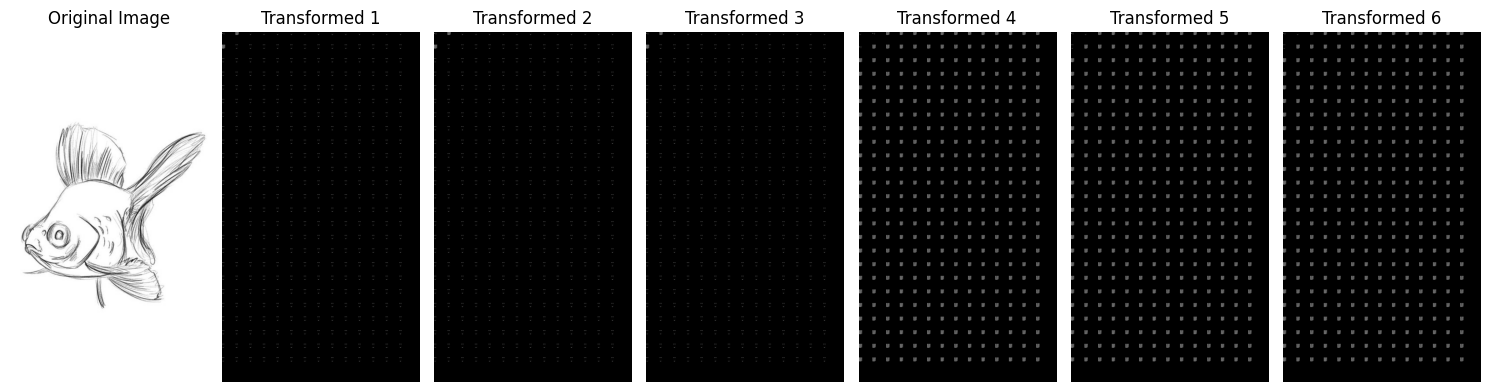

In [32]:
# 예시: 학습 이미지 중 하나를 선택하여 변환 및 시각화
image = cv2.imread('./data/train/n01443537/sketch_3.JPEG', cv2.IMREAD_COLOR)  # 원본 스케치 이미지 경로
visualize_bpd_msr(image, cluster_centers, msr_ratio=0.5, num_deformations=6)